<a href="https://colab.research.google.com/github/diro5t/deep_quadric_learning/blob/main/DQL_Episode2_Quadric_Neuron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Deep Quadric Learning - A tale in 4 episodes
## Episode 2: The Quadric Neuron
### (C) Dirk Roeckmann 2023

https://scholar.google.com/citations?hl=en&user=hamuGh4AAAAJ

# Introduction

In this episode, I will define the single quadric neuron proper in comparison to the ubitiquous linear neuron. I will compare their parameter complexities and finally use PyTorch to let a single quadric neuron model learn to classify some data.

# The Quadric Neuron

In the last episode I formulated the simplified equation of a quadric without mixed terms. Now I will use it to define a single quadric neuron of dimension $n$. The neuron has $n$ inputs $i_k$, one output $o$, $n$ linear weights $w_k$, $n$ quadratic weights $q_k$ and one bias value $b$. Equation (1) denotes the behavior:

\begin{equation}
o = \sum_{k=1}^n q_k i_k^2 + \sum_{k=1}^n w_k i_k + b \tag{1}
\end{equation}

In terms of complexity the neuron has $2n+1$ parameters - one forward pass needs $3n$ multiplications and $2n+1$ additions.

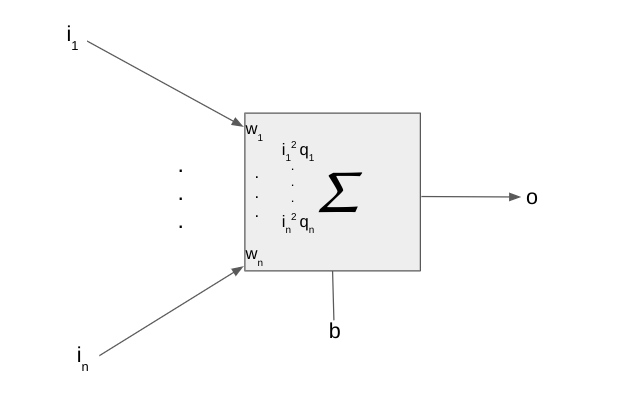


## By comparison: The Linear Neuron

The vanilla linear neuron of dimension n has $n$ inputs $i_k$, one output $o$ and $n$ linear weights $w_k$ and one bias value $b$:

\begin{equation}
o = \sum_{k=1}^n w_k i_k + b \tag{2}
\end{equation}

In comparison to the quadric neuron, the linear neuron has only $n+1$ parameters and a forward-pass needs only $n$ multiplications and $n+1$ additions.

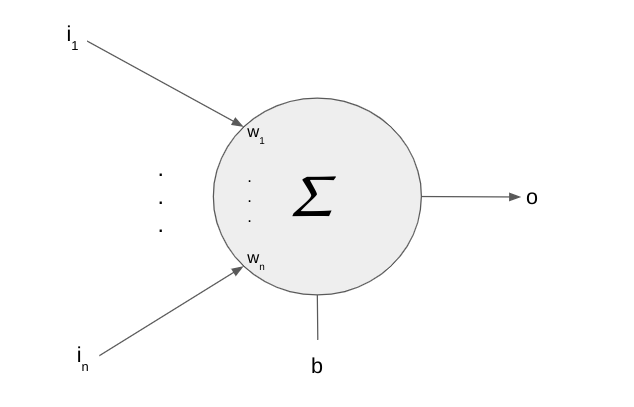

This begs the question: Why considering quadric neurons when they need more parameters and operations than their linear counterparts? I postulate that the superior separation power of quadric neurons in multilayer models outweighs the parameter overhead and in the end will reduce, not increase net model size.

# Binary classification with a single quadric neuron

For demonstration purposes, I will use a small toy data set of circular data points which will demonstrate the separation capabilities of a single quadric neuron.

## Create some data points
For this little toy example let's create a 1000 circular datapoints in 2 classes:

In [ ]:
# create some circular data points
import sklearn
from sklearn.datasets import make_circles
samples = 1000
X, y = make_circles(samples, noise=0.03, random_state=99)

In [ ]:
# tabular visualization
import pandas as pd
data = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "class": y})
data.head(10)

,X1,X2,class
0,0.144241,-0.804075,1
1,0.819312,-0.174175,1
2,0.245470,0.975640,0
3,0.187504,0.834055,1
4,0.145504,0.996502,0
5,-0.309741,-0.955888,0
6,0.941360,0.235583,0
7,-0.212676,0.990582,0
8,-0.466400,0.676852,1
9,0.828470,0.493537,0


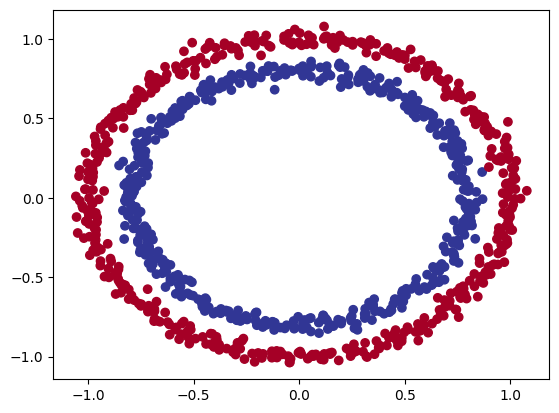

In [ ]:
# graphical visualization
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)

## Split data points into training and test data set

Let's go to PyTorch, transfer the data points into tensors and split them 80/20 into training and test data sets respectively.

In [ ]:
import torch
from torch import nn
import math
torch.__version__

'2.0.1+cu118'

In [ ]:
# input tensor
I = torch.from_numpy(X).type(torch.float)
# output tensor
o = torch.from_numpy(y).type(torch.float)
# let's look at the first 10 data points
I[:10], o[:10]

(tensor([[ 0.1442, -0.8041],
         [ 0.8193, -0.1742],
         [ 0.2455,  0.9756],
         [ 0.1875,  0.8341],
         [ 0.1455,  0.9965],
         [-0.3097, -0.9559],
         [ 0.9414,  0.2356],
         [-0.2127,  0.9906],
         [-0.4664,  0.6769],
         [ 0.8285,  0.4935]]),
 tensor([1., 1., 0., 1., 0., 0., 0., 0., 1., 0.]))

In [ ]:
# split'em up
from sklearn.model_selection import train_test_split
I_train, I_test, o_train, o_test = train_test_split(I, o, test_size=0.2, random_state=99)
# verify
len(I_train), len(o_train), len(I_test), len(o_test)

(800, 800, 200, 200)

## Model class for singular quadric neuron

Let's define a model class for a single quadric neuron with two inputs for the circular toy data points, in other words a simplified quadric without mixed terms in the Euclidean Plane (see Episode 1).

\begin{equation}
o =  q_1 i_1^2 + q_2 i_2^2 + w_1 i_1 + w_2 i_2 + b \tag{3}
\end{equation}

In [ ]:
class QuadricNeuronR2(nn.Module):
  # constructor
  def __init__(self):
    super().__init__()
    # model parameters
    # quadratic weights
    q = torch.Tensor(1, 2)
    self.q = nn.Parameter(q)
    # linear weights
    w = torch.Tensor(1, 2)
    self.w = nn.Parameter(w)
    # bias
    b = torch.Tensor(1)
    self.b = nn.Parameter(b)
    # initialize
    nn.init.kaiming_uniform_(self.q, a=math.sqrt(5))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.q)
    nn.init.kaiming_uniform_(self.w, a=math.sqrt(5))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.w)
    bound = 1 / math.sqrt(fan_in)
    nn.init.uniform_(self.b, -bound, bound)

  # forward method to define the computation in the model
  def forward(self, i: torch.Tensor) -> torch.Tensor:
    isqr = torch.mul(i, i)
    qi = torch.mm(isqr, self.q.t())
    wi = torch.mm(i, self.w.t())
    o = torch.add(torch.add(qi, wi), self.b)
    return o

In [ ]:
# instantiate model and check parameters
torch.manual_seed(99)
qmodel = QuadricNeuronR2()
qmodel.state_dict()

OrderedDict([('q', tensor([[-0.5610,  0.6649]])),
             ('w', tensor([[0.6337, 0.6770]])),
             ('b', tensor([-0.2450]))])

## Inference of untrained model

In [ ]:
# inference on some test set data points with untrained model (just checking)
with torch.inference_mode():
  o_untrained = torch.round(torch.sigmoid(qmodel(I_test).squeeze()))[:10]
o_untrained

tensor([1., 1., 1., 0., 0., 0., 0., 0., 1., 0.])

In [ ]:
# import function for showing decision boundary
# courtesy of Daniel Bourke
import requests
from pathlib import Path
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Download helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_decision_boundary

Download helper_functions.py


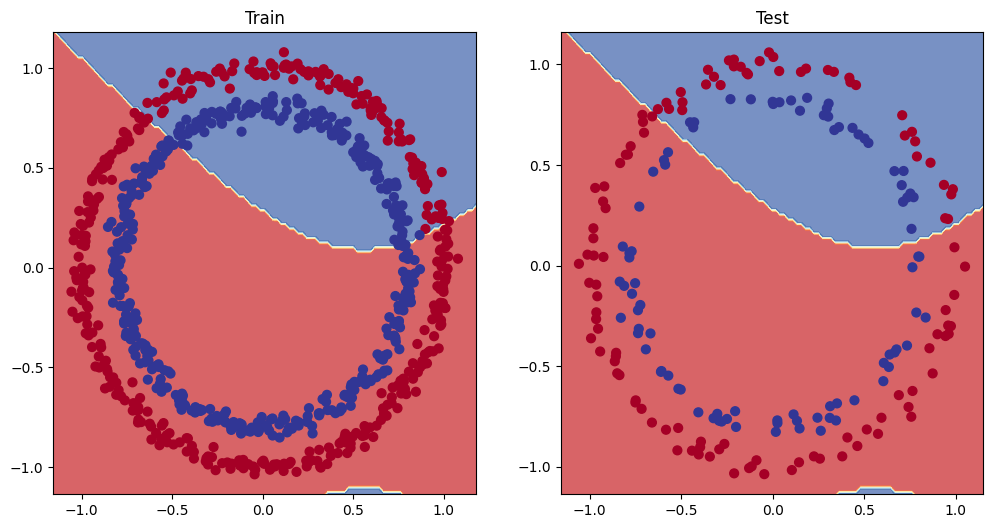

In [ ]:
# visualize the decision boundary of the untrained model for training and test data
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(qmodel, I_train, o_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(qmodel, I_test, o_test)

We can clearly see that the randomly initialized quadric neuron has indeed a second order decision boundary which forms a hyperbola in the initialization state.

# Model training

## Define loss function and optimizer

The single neuron model is trained with Binary Cross Entropy loss and Stochastic Gradient Descent for the binary classification task

In [ ]:
# loss function
loss_fn = nn.BCELoss()

# optimizer
optimizer = torch.optim.SGD(params=qmodel.parameters(), lr=0.5)

## Training and test loop

Let it run.

Note: This is just a proof of concept example, so no steps of hyperparameter optimization etc. have been taken.

In [ ]:
# reproducibility
torch.manual_seed(99)

# number of epochs
epochs = 10000

# build training and evaluation loop
for epoch in range(epochs):
  # training
  qmodel.train()

  # forward pass
  pred = torch.sigmoid(qmodel(I_train).squeeze())

  # training loss, accurracy
  loss = loss_fn(pred, o_train)

  # optimizer zero grad
  optimizer.zero_grad()

  # loss backward (backpropagation)
  loss.backward()

  # optimizer step (gradient descent)
  optimizer.step()

  # testing
  qmodel.eval()
  with torch.inference_mode():
    # forward pass
    test_pred = torch.sigmoid(qmodel(I_test).squeeze())

    # test loss, accurracy
    test_loss = loss_fn(test_pred, o_test)

    # log stuff
    if epoch % 1000 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f} Test loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.76477 Test loss: 0.74077
Epoch: 1000 | Loss: 0.19018 Test loss: 0.20797
Epoch: 2000 | Loss: 0.11069 Test loss: 0.12708
Epoch: 3000 | Loss: 0.07970 Test loss: 0.09448
Epoch: 4000 | Loss: 0.06312 Test loss: 0.07662
Epoch: 5000 | Loss: 0.05274 Test loss: 0.06522
Epoch: 6000 | Loss: 0.04558 Test loss: 0.05724
Epoch: 7000 | Loss: 0.04033 Test loss: 0.05131
Epoch: 8000 | Loss: 0.03631 Test loss: 0.04671
Epoch: 9000 | Loss: 0.03312 Test loss: 0.04302


## Inference of trained model

We can clearly see the learned quadric (ellipsis) which correctly classifies the training and test data.

In [ ]:
# parameters of the trained model
qmodel.state_dict()

OrderedDict([('q', tensor([[-22.9619, -22.9363]])),
             ('w', tensor([[-0.0757,  0.1406]])),
             ('b', tensor([18.7513]))])

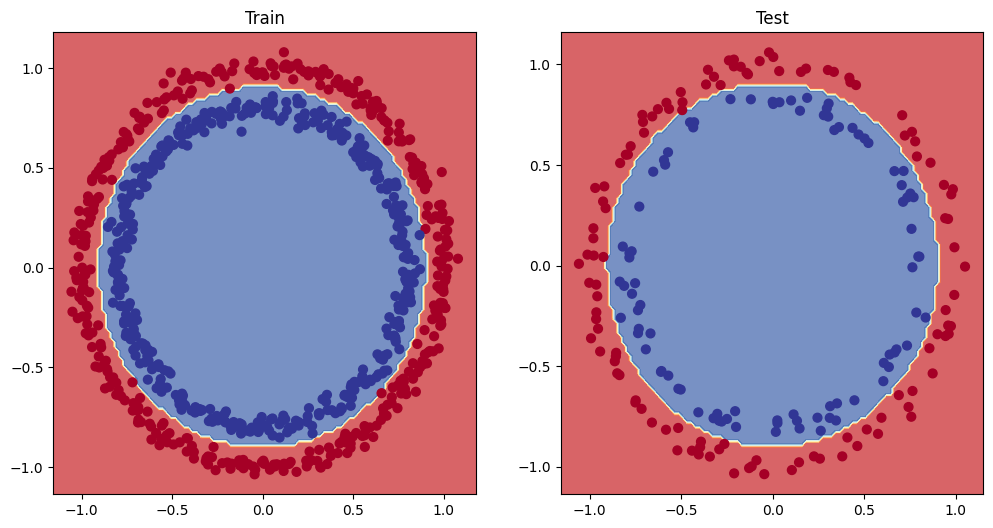

In [ ]:
# visualize the decision boundary of the trained model for training and test data
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(qmodel, I_train, o_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(qmodel, I_test, o_test)

# Teaser Episode 3: Quadric Layers

After having trained a single neuron quadric model to correctly classify data for which otherwise a multi-layer multi-unit model with linear neurons would have been needed, Episode 3 will make the case for introducing quadric layers in PyTorch.